# Gradient Descent with Automatic Differentiation Tutorial

The goal of this tutorial is to introduce the use gradient descent for model fitting using a modern approach that employs automatic differentiation to compute gradients. We'll learn how to using an automatic differentiation package called Autograd and use to train a neural network model on a classical problem of digit recognition. The most code is already written for you, but there will be some opportunities to experiment. The treatment here is meant introduce the approach-- don't expect a lot of rigor!


# Gradient Descent

Gradient descent is a simple technique for minimizing the error between the predictions of a model and the data it aims to predict. Its strength lies in its wide applicability; an model with differentiable error metric can be optimized using gradient descent.

Let's assume the system we are trying to model takes an input $x$ and produces an output $y$. Using some parameters $\theta$ our model takes the same input $x$ and makes prediction $\hat y = f(x;\theta)$. Given an error metric for individual predictions $E(y,\hat y)$ the total error in our model is just the average over the data: 

$$\frac{1}{N} \sum_{x_n, y_n \in \mathcal D} E(y_n, f(x_n; \theta))$$

To minimize the error of our model with respect to the parameters we can just take small steps down the gradient: 

$$\Delta \theta = -\frac{\eta}{N} \sum_n \nabla_\theta E(y_n, f(x_n; \theta))$$ 

where $\eta$ is a step size parameter we must choose known as the learning rate.

In practice, computing the gradient from the entire dataset can be costly, and it's often more efficient to use some subset of the data to get an estimate of the estimate of the gradient and start taking steps. This approach is known as stochastic gradient descent (SGD) because each subset of the data gives a noisy estimate of the full gradient. As long as the step size is small enough SGD will converge to same solution and it will often get there faster. In fact, often the most popular approach and the one we'll use here is to just take gradient with respect to individual data points!

# Automatic Differentiation

Computing gradients by hand is usually not too difficult. However, if your model is complicated there can be lots of opportunities to make mistakes-- both in the math and in translating the math into code. Fortunately, the process of computing gradients is mechanical enough that computers themselves are quite good at it. Recently, the use of software packages that can perform automatic differentiation have been quite popular, particular in the community of researchers working on neural network algorithms.

A bunch of such packages exist. Three of the more popular one are:
* [Theano](http://deeplearning.net/software/theano/): a Python based framework. There are an extensive set of examples using Theano for deeplearning at http://www.deeplearning.net/tutorial/
* [Torch](http://torch.ch/): a Lua based framework with extensive support for convultional neural networks.
* [Caffe](http://caffe.berkeleyvision.org/) a C++ based framework. Because it's written C++ it's probably the fastest neural net/automatic differentiation framework out there. Developed at Berkeley!

In addition to automatic differentiation, another notably feature all three frameworks is the integration GPU computation which significantly speeds up the training of large models.

Here we are going to use yet another package called Autograd. Autograd hasn't been as extensively developed as Theano and Torch (for example it doesn't support GPU computation yet), but it uses Python (unlike Torch) and it's a lot simpler to learn than Theano (principly because it doesn't require compilation) so it seems like a good choice for the tutorial. 

# Installation

The first step in this tutorial to install Autograd. This simplest way is with pip:

    pip install autograd
    
If you're familiar with git their repository is here: https://github.com/HIPS/autograd/

# Basic Examples

We're ready to start writing some code. Autograd is built on top of numpy. We'll need autograd's wrapped version of numpy and grad function to compute graidents. Also we'll use matplotlib to plot stuff.

In [1]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 6.0)

Let's try it out. Plot the sine function over the range $-\pi$ to $\pi$, take the it's derivative using autograd, and plot that over the same range.  Which function does the derivative plot look like?

(-3.141592653589793, 3.141592653589793)

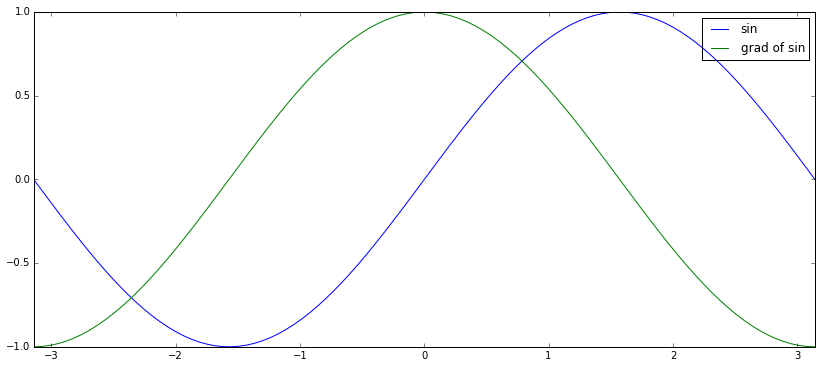

In [2]:
x = np.linspace(-np.pi, np.pi, 100)
grad_sin = grad(np.sin)
plt.plot(x, np.sin(x), label = 'sin')
plt.plot(x, map(grad_sin, x), label = 'grad of sin') 
plt.legend()
plt.xlim(-np.pi, np.pi)

Now we're going to work with some multidimensionsal functions and start using gradient descent. First we'll create some  a simple 2D quadratic function: $y = x^T A x + b^T x + c$.

<matplotlib.colorbar.Colorbar instance at 0x7fa8a6f427a0>

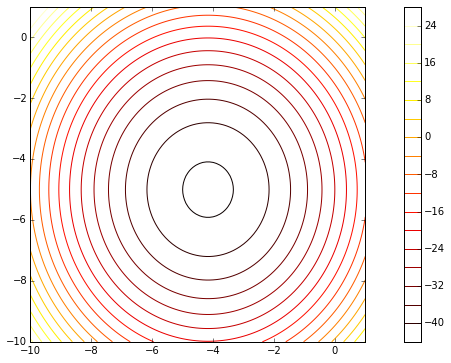

In [3]:
A_true = np.array([[1.2, 0], [0, 1]])
b_true = 10*np.ones([2])
c_true = 1.0
def simple_quadratic(x, A, b, c):
    return np.dot(x.T, np.dot(A, x)) + np.dot(b,x) + c

# Iterative compute and plot the quadratic's values in small window
x_range = np.linspace(-10, 1, 100)
[x1_grid, x2_grid] = np.meshgrid(x_range, x_range)
x_grid = np.vstack([x1_grid.flat, x2_grid.flat])
y_grid = np.zeros(x_grid.shape[1])
for ii in xrange(x_grid.shape[1]):
    y_grid[ii] = simple_quadratic(x_grid[:,ii], A_true, b_true, c_true)
plt.contour(x1_grid, x2_grid, np.reshape(y_grid, x1_grid.shape), 20)
plt.gca().set_aspect('equal')
plt.colorbar()

Now we'll use gradient descent to find the minimum of this quadratic. There are more direct ways of finding the minimum of a quadratic so this is just for illustrative purposes. 

Note: the grad function in Autograd takes the gradient of function wrt to it's first argument.

We start x at the origin and plot the history of it's values as it descends.

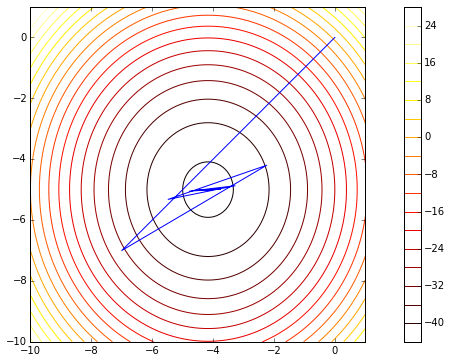

In [4]:
grad_simple_quad = grad(simple_quadratic)

n_iter = 10
x_hist = np.zeros([2, n_iter + 1])
y_hist = np.zeros(x_hist.shape[1])
y_hist[0] = simple_quadratic(x_hist[:,0], A_true, b_true, c_true)

eta = .7 # the learning rate


for ii in xrange(n_iter):
    x_hist[:, ii + 1] = x_hist[:,ii] - eta*grad_simple_quad(x_hist[:, ii], A_true, b_true, c_true)
    y_hist[ii + 1] = simple_quadratic(x_hist[:,ii+1], A_true, b_true, c_true)
    
plt.contour(x1_grid, x2_grid, np.reshape(y_grid, x1_grid.shape), 20)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.plot(x_hist[0,:], x_hist[1,:])

Notice how the optimization trajectory overshoots the minimum and then oscillates back and forth on either side of iit as it closes in. This is because we (evilly!) set the learning rate too large. Try reducing the learning rate to get smoother convergence. 

What happens if you increase the learning rate beyond the value we originally set it to. Can you explain why this is happening?

One issue with gradient descent is that while gradient provides information about what direction to change your parameter, it doesn't indicate how far to travel in that direction. Thus, the learning rate must be set carefully.

# The MNIST dataset

In the next part of the tutorial we are going to train a simple neural network train to classify hand-written digit images. The images come from the MNIST dataset, a popular benchmark dataset for neural network algorithms. First we'll load up the dataset and show what the digit images look like:

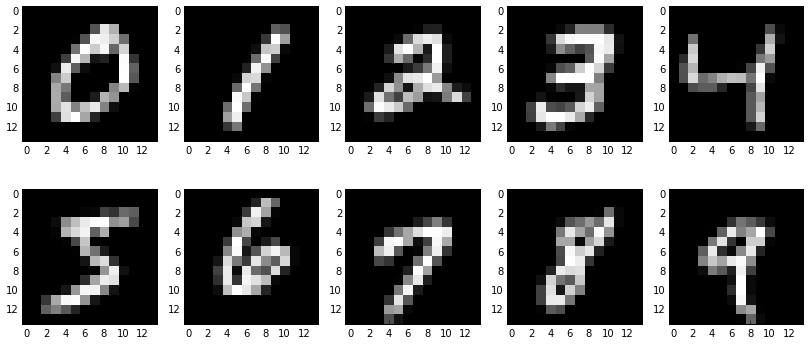

In [5]:
from scipy.io import loadmat
data_dir = "data/"
data_file = "mnist.mat"

n_digits = 10

data = loadmat(data_dir + data_file)
IMAGES = data['IMAGES']
LABELS = data['LABELS'].flatten()

for ii in xrange(10):
    plt.subplot(2,5, ii + 1)
    plt.imshow(IMAGES[np.where(LABELS == ii)[0][0], :, :])
    plt.gray()
    
# The data and labels as loaded are in order by digit, but in general it's better to go to train on I.I.D. data
# so permute them
order = np.random.permutation(IMAGES.shape[0])
IMAGES = IMAGES[order]
LABELS = LABELS[order]

# Reshape the images into a matrix of input vectors and z-score them. This is often a helpful preprocessing step
X = np.reshape(IMAGES, [IMAGES.shape[0], IMAGES.shape[1]*IMAGES.shape[2]]).astype(np.float32)
X -= np.mean(X, 1, keepdims = True)
X /= np.std(X, 1, keepdims = True)


A critical step in training machine learning algorithms is to split up your data set into test and training portions. Why? A key problem with complex models is that they often capable of overfitting the data they are trained on; a model the makes good predictions about data it has seen but terrible predictions about new data of the type generally isn't a very useful model. We'll use 90%/10% split of training/test data. If there's less data available you may want to consider dedicating more to test set or making using [k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))

In [6]:
[n_images, input_dim] = X.shape
n_train = np.int(.9*n_images)
X_train = X[:n_train]
X_test = X[n_train:]
LABELS_train = LABELS[:n_train]
LABELS_test = LABELS[n_train:]

# Training a multilayer neural network

Artificial neural networks attempt to model input-output relationships by adjusting the strength of connection between the units (aka "neurons") within the network. Most commonly used type of units are simple linear-non-linear unit (sometimes referred to at McCullough-Pitts units) that computes a linear sum of its inputs followed by a non-linearity. While a single layer of such units is very limited in the input-output mappings that it can express, remarkable just two layers are enough to approximate any continuous functio! See https://en.wikipedia.org/wiki/Universal_approximation_theorem for more detail. 

The layers of units that aren't used to directly produce the output of network are called hidden layers. First we're going train a 2-layer network so there will only be one hidden layer. We'll use the hyperbolic tangent as our hidden unit nonlinearity which looks like this: 

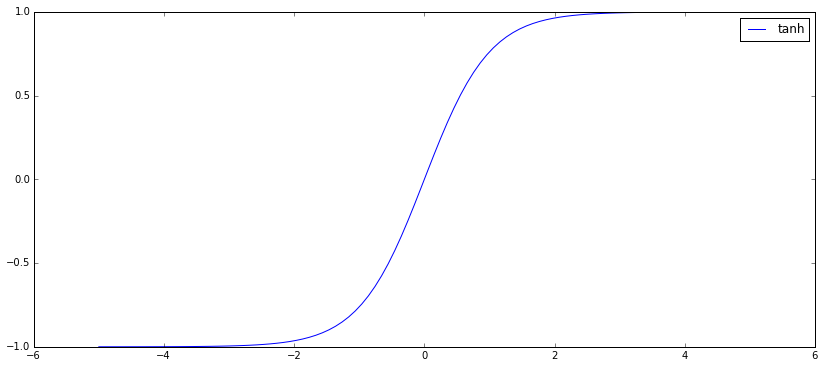

In [7]:
x = np.linspace(-5, 5, 100)
plt.plot(x, np.tanh(x), label = 'tanh')
plt.legend()

We'll also need a non-linearity for our output units. A good choice of output non-linearity depend upon the type output signal we're hoping to model. Here we'll be classifying hand-written digits as the numbers 0-9. A good choice of output is to have one output unit per number and have the output of each unit represent the probability that the hand-written digit is corresponding number. We accomplish this the using the softmax output non-linearity; it takes a real-valued set of outputs and normalizes them to probabilities:
$$\mbox{softmax}(y_i) = \frac{\exp(y_i)}{\sum_j \exp(y_j)}$$

Finally we'll need to specify our error function for the network. A reasonable choice is to use the negative log probability of the digit's true class. This will be large when probability of the correct digit is small and small when correct digit is assigned a high probability. Using the logarithm also help account for the fact the difference between small probabilities are very significant-- assign an event zero probability is an expression of extreme confidence and it's a catastrophic error if the event end up happening.

Let's summarize the full model in matrix notation: Our inputs $x$ are the digit images. To determine activity of the hidden units $h$ we multiply these inputs by hidden unit connectivity weights $W_h$, add the hidden biases $b_h$, and map through the $\tanh$ nonlinearity. to determine the hidden actv output units $y$ with weights $W_y$, and digit probabilities $p$. We compute them as:
$$h = \tanh(x^T W_h + b_h)$$
$$y = h^T W_y  + b_y$$
$$p_i = \mbox{softmax}(y_i)$$

In [12]:
n_hidden = 100

# Initialize the weights using a standard random gaussian initialization
W_h = np.random.randn(input_dim, n_hidden)/np.sqrt(input_dim)
b_h = np.zeros(n_hidden)
W_y = np.random.randn(n_hidden, n_digits)/np.sqrt(n_hidden)
b_y = np.zeros(n_digits)

def softmax(y):
    z = np.exp(y)
    return z/np.sum(z,1, keepdims=True)

def predict_digit(W_h, b_h, W_y, b_y, x):
    h = np.tanh(np.dot(x, W_h) + b_h)
    y = np.dot(h, W_y) + b_y
    p = softmax(y)    
    return p

Now we'll define the loss function compute its gradient. For our loss function we'll use the negative predicted negative log-probability of the true class, i.e. if $i*$ is the index of the correct digit class, then our loss will be $p_{i^*}$. Thus, if the network predicts that the true class if has probability close to 1 the loss will be nearly zero, but if the network predicts that probability of seeing the true class if small then the loss will be large.

Since the grad function in autograd always differentiaties only with respect to the first argument of a function, to compute the gradient w.r.t. all of the parameters we'll need to pack all of the network parameters into a single first argument vector.

In [9]:
def pack_params(param_list):
    shapes = [param.shape for param in param_list]
    sizes = [np.prod(shape) for shape in shapes]
    param_vec = np.zeros(np.sum(sizes))
    start_idx = 0
    for (param, size) in zip(param_list, sizes):
        param_vec[start_idx:start_idx+size] = np.reshape(param, size)
        start_idx += size

    return param_vec, shapes

def unpack_params(param_vec, shapes):
    sizes = [np.prod(shape) for shape in shapes]
    start_idx = 0
    param_list = []
    for (shape, size) in zip(shapes, sizes):
        param_list.append(np.reshape(param_vec[start_idx:start_idx+size], shape))
        start_idx += size
        
    return param_list

lambda_l2_reg = 1e-5

def loss(param_vec, shapes, x, label):
    [W_h, b_h, W_y, b_y] = unpack_params(param_vec, shapes)
    
    p = predict_digit(W_h, b_h, W_y, b_y, x)
    
    mean_cross_entropy = -np.mean(np.log(p[label]))
    
    return mean_cross_entropy + lambda_l2_reg*np.dot(param_vec, param_vec)

grad_loss = grad(loss)

def compute_classification_error(param_vec, shapes, X, LABELS):
    [W_h, b_h, W_y, b_y] = unpack_params(param_vec, shapes)
    P = predict_digit(W_h, b_h, W_y, b_y, X)
    best_digit = np.argmax(P,1)
    
    return np.sum(best_digit != LABELS)/np.float(len(LABELS))

We're ready to start training. Pack the initial parameters into parameter vector and take small steps down the gradient to reduce the loss function.

In [14]:
[param_vec, shapes] = pack_params([W_h, b_h, W_y, b_y])

eta = 1e-2
batch_size = 100
n_batches = n_train/batch_size
n_epoch = 20


loss_hist = np.zeros([n_batches, n_epoch])
test_error_hist = np.zeros(n_epoch)
train_error_hist = np.zeros(n_epoch)

for jj in xrange(n_epoch):
    batch_start = 0
    for ii in xrange(n_batches):

        batch_inds = np.arange(batch_start,batch_start+batch_size)

        loss_hist[ii, jj] = loss(param_vec, shapes, X_train[batch_inds], LABELS[batch_inds])
        param_vec -= eta*grad_loss(param_vec, shapes, X_train[batch_inds], LABELS[batch_inds])

        batch_start += batch_size


    [W_h, b_h, W_y, b_y] = unpack_params(param_vec, shapes)
        
    train_error_hist[jj] = compute_classification_error(param_vec, shapes, X_train, LABELS_train)
    test_error_hist[jj] = compute_classification_error(param_vec, shapes, X_test, LABELS_test)

plt.plot(np.arange(n_epoch), np.mean(loss_hist,0))
plt.title('Average training loss vs. epoch')
    
# plt.plot(train_error_hist, label='train_error')
# plt.plot(test_error_hist, label='test_error')
# plt.legend()


KeyboardInterrupt: 

Now that we've initial network implemented it your turn to start experimenting. Increase or decrease the number of hidden units. How does the number hidden units affect the training error? The test error?

Modify the network to add a second hidden layer.